<a href="https://colab.research.google.com/github/vicky1412/Predicting_stocks_usiang_deep_learning-models/blob/main/options_trading_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install alpha_vantage

## Imports

In [ ]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Create API object

In [ ]:
from alpha_vantage.foreignexchange import ForeignExchange

API_Key = 'GICCCRW4PJWT0C9'
ts = ForeignExchange(key=API_Key,output_format='pandas')

In [ ]:
data = ts.get_currency_exchange_intraday(from_symbol='EUR', to_symbol='USD', interval='1min', outputsize='full')[0]
data

## Data Manipulation

In [ ]:
# Rename the columns
data.rename(columns = {'1. open':'Open'}, inplace = True)
data.rename(columns = {'2. high':'High'}, inplace = True)
data.rename(columns = {'3. low':'Low'}, inplace = True)
data.rename(columns = {'4. close':'Close'}, inplace = True)
# reverse it
data = data.iloc[::-1]
# set Index
data['Index'] = np.arange(len(data))
data.set_index('Index',inplace=True)

def Diff_body(row):
  return abs(row['Open']-row['Close'])
def Diff_wick(row):
  return abs(row['High']-row['Low'])
def Current(row):
  id = row.name + 1
  try:
    return data.iloc[[id],[3]].values[0][0]
  except:
    return data.iloc[[id-1],[3]].values[0][0]
def Next(row):
  id = row.name + 2
  try:
    return data.iloc[[id],[3]].values[0][0]
  except:
    return data.iloc[[id-2],[3]].values[0][0]

# Get the color(candles)
data['Diff_body'] = data.apply (lambda row: Diff_body(row), axis=1)
data['Diff_wick'] = data.apply (lambda row: Diff_wick(row), axis=1)
data['Current'] = data.apply (lambda row: Current(row), axis=1)
data['Next'] = data.apply (lambda row: Next(row), axis=1)

In [ ]:
data

## Split data into X and Y

In [ ]:
X = data.drop(['Current','Next'], axis=1)
Y1 = data['Current']
Y2 = data['Next']

In [ ]:
X

## Split data into train and test sets

In [ ]:
# Split data into train and test sets
np.random.seed(42)
# Split into train & test set
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X,Y1,test_size=0.2)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X,Y2,test_size=0.2)

In [ ]:
X1_train.shape,X1_test.shape

((896, 6), (224, 6))

## Modeling

In [ ]:
# Create function to evaluate model on a few different levels
def show_scores(model,X_train,X_test,Y_train,Y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    y_train = Y_train
    y_test = Y_test

    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Test MAE": mean_absolute_error(y_test, test_preds),
              "Training MSE": mean_squared_error(y_train, train_preds),
              "Test MSE": mean_squared_error(y_test, test_preds)}
    return scores

In [ ]:
rf_grid = {"n_estimators": np.arange(1,50000, 1)}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X2_train, Y2_train)

In [ ]:
rs_model.best_params_

In [ ]:
show_scores(rs_model,X2_train,X2_test,Y2_train,Y2_test)

In [ ]:
modelcurrent = RandomForestRegressor(n_jobs=-1,n_estimators=1114)
modelcurrent.fit(X1_train, Y1_train);

In [ ]:
modelnext = RandomForestRegressor(n_jobs=-1,n_estimators=1609)
modelnext.fit(X2_train, Y2_train);

In [ ]:
modelcurrent.score(X1_test,Y1_test)

In [ ]:
modelnext.score(X2_test,Y2_test)

In [ ]:
show_scores(modelcurrent,X1_train,X1_test,Y1_train,Y1_test)

In [ ]:
show_scores(modelnext,X2_train,X2_test,Y2_train,Y2_test)

In [ ]:
mse_modelcurrent = 0.00017
mse_modelnext = 0.00016

## Predict

In [ ]:
predictions = model.predict(X_test)
mse = np.mean(predictions - Y_test)**2
mse

0.0604766464

## Save Model

In [ ]:
import pickle

Filename1 = "model-1m-regressor(current).pkl"  
Filename2 = "model-1m-regressor(next).pkl"  

with open(Filename1, 'wb') as file:  
    pickle.dump(model1, file)
with open(Filename2, 'wb') as file:  
    pickle.dump(model2, file)

## Realtime

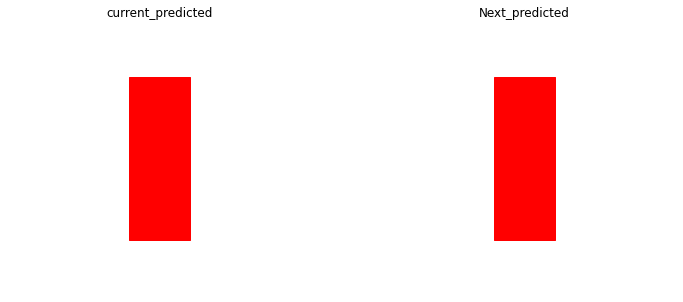

In [ ]:
datas = ts.get_currency_exchange_intraday(from_symbol='EUR', to_symbol='USD', interval='1min', outputsize='full')[0]
# Rename the columns
datas.rename(columns = {'1. open':'Open'}, inplace = True)
datas.rename(columns = {'2. high':'High'}, inplace = True)
datas.rename(columns = {'3. low':'Low'}, inplace = True)
datas.rename(columns = {'4. close':'Close'}, inplace = True)
# set Index
datas['Index'] = np.arange(len(datas))
datas.set_index('Index',inplace=True)
# Add Diff column
def Diff_bodys(row):
  return abs(row['Open']-row['Close'])
def Diff_wicks(row):
  return abs(row['High']-row['Low'])
# Get the diff(candles)
datas['Diff_body'] = datas.apply (lambda row: Diff_bodys(row), axis=1)
datas['Diff_wick'] = datas.apply (lambda row: Diff_wicks(row), axis=1)
final_datas = datas.iloc[datas.index==0]
pd.options.display.float_format = '{:,.5f}'.format
# Predict
predictions_current = modelcurrent.predict(final_datas)[0]
predictions_next = modelnext.predict(final_datas)[0]

mse_current = 0.00017
mse_next = 0.00016

previous_close = final_datas['Close'].values[0]

# Virtualize
fig, ax = plt.subplots(1,2,figsize=(12,5))
# Title
ax[0].set(title="current_predicted", xlabel="Height", ylabel="Width")
ax[1].set(title="Next_predicted", xlabel="Height", ylabel="Width")
# X and Y limit
ax[0].set_xlim(0,5)
ax[0].set_ylim(0,5)
ax[1].set_xlim(0,5)
ax[1].set_ylim(0,5)
# hide grid
ax[0].grid(False)
ax[1].grid(False)
# hide axis
ax[0].axis('off')
ax[1].axis('off')

def rects(axx,ayy,width,height,cancolor):
  rect = matplotlib.patches.Rectangle((axx, ayy),width, height,color =cancolor)
  return rect

# predictions_current
if previous_close < (predictions_current):
  rect = rects(2,1,1,3,'green')
  ax[0].add_patch(rect)
elif previous_close > (predictions_current):
  rect = rects(2,1,1,3,'red')
  ax[0].add_patch(rect)
else:
  rect = rects(2,1,1,3,'black')
  ax[0].add_patch(rect)
# predictions_next
if previous_close < (predictions_next):
  rect = rects(2,1,1,3,'green')
  ax[1].add_patch(rect)
elif previous_close > (predictions_next):
  rect = rects(2,1,1,3,'red')
  ax[1].add_patch(rect)
else:
  rect = rects(2,1,1,3,'black')
  ax[1].add_patch(rect)

In [ ]:
predictions_current,predictions_next

(1.177897548960293, 1.1778849859531009)

In [ ]:
ds = ts.get_currency_exchange_intraday(from_symbol='EUR', to_symbol='USD', interval='1min', outputsize='full')[0]
ds.head()

,1. open,2. high,3. low,4. close
date,,,,
2021-07-26 05:01:00,1.17770,1.17788,1.17760,1.17760
2021-07-26 05:00:00,1.17784,1.17790,1.17770,1.17785
2021-07-26 04:59:00,1.17792,1.17792,1.17770,1.17780
2021-07-26 04:58:00,1.17780,1.17800,1.17780,1.17790
2021-07-26 04:57:00,1.17788,1.17790,1.17770,1.17789
